## 🐠🦀🐙Classifying Sea 🌊 Animals 🐬🐳🦑

In [1]:
import os
import math
import random
from typing import Dict, List,Tuple
import requests

import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path, PurePath
import pathlib
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets, models
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn

from PIL import Image

import mlflow
import mlflow.pytorch

# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# from imutils import paths

# import splitfolders
import textwrap


In [2]:
# mlflow config
mlflow.set_experiment("Sea Animals Classification")

<Experiment: artifact_location='file:///home/marc/Documents/2401ftds/git-workshop/mlruns/234771502956866209', creation_time=1719379380727, experiment_id='234771502956866209', last_update_time=1719379380727, lifecycle_stage='active', name='Sea Animals Classification', tags={}>

# Dataset Structure

This notebook template is for data that is already in ImageFolder format.

If you are unfamiliar with ImageFolder format, it looks like this:

```
├── train
│   ├── class1
|      ├── 1.jpg
│      ├── 2.jpg
│   ├── class2
|      ├── 1.jpg
│      ├── 2.jpg
├── valid
│   ├── class1
|      ├── 1.jpg
│      ├── 2.jpg
│   ├── class2
|      ├── 1.jpg
│      ├── 2.jpg
```

With parent folder repeating for validtaion and testing data.

### Number of classes

Simple utility to fetch the number of classes.

In [3]:
from pathlib import Path

data_dir = 'Data/Sea Animals'

def count_subdirectories(path: str) -> int:
    """
    Counts the number of subdirectories in the given directory path.
    """
    dir_path = Path(path)
    subdirectories = [f for f in dir_path.iterdir() if f.is_dir()]
    return len(subdirectories)

# Example usage
num_subdirectories = count_subdirectories(data_dir)
print(f"Number of subdirectories in {data_dir}: {num_subdirectories}")

Number of subdirectories in Data/Sea Animals: 23


### Dataset Loading

#### Transformations

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224 pixels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

In [5]:
# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [6]:
# Define the train, validation, and test split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the sizes of each dataset split
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

In [7]:
# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [8]:
# Create DataLoaders for each split
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Check the sizes of each DataLoader
print(f'Train dataset size: {len(train_loader.dataset)}')
print(f'Validation dataset size: {len(val_loader.dataset)}')
print(f'Test dataset size: {len(test_loader.dataset)}')

Train dataset size: 9597
Validation dataset size: 2056
Test dataset size: 2058


In [10]:

# Example: Iterate through the train_loader
for images, labels in train_loader:
    print(images.size(), labels.size())
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


### Visualise the Dataset

In [11]:
# Function to visualize sample images from each class
def visualise_class_images(dataset, class_names):
    num_classes = len(class_names)
    num_columns = 5
    num_rows = (num_classes + num_columns - 1) // num_columns
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 3))
    axes = axes.flatten()

    for i, class_name in enumerate(class_names):
        class_index = dataset.class_to_idx[class_name]
        class_indices = [idx for idx, (_, label) in enumerate(dataset.samples) if label == class_index]
        sample_idx = random.choice(class_indices)
        image_path, _ = dataset.samples[sample_idx]
        image = plt.imread(image_path)

        axes[i].imshow(image)
        axes[i].set_title(class_name)
        axes[i].axis('off')

    for ax in axes[num_classes:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

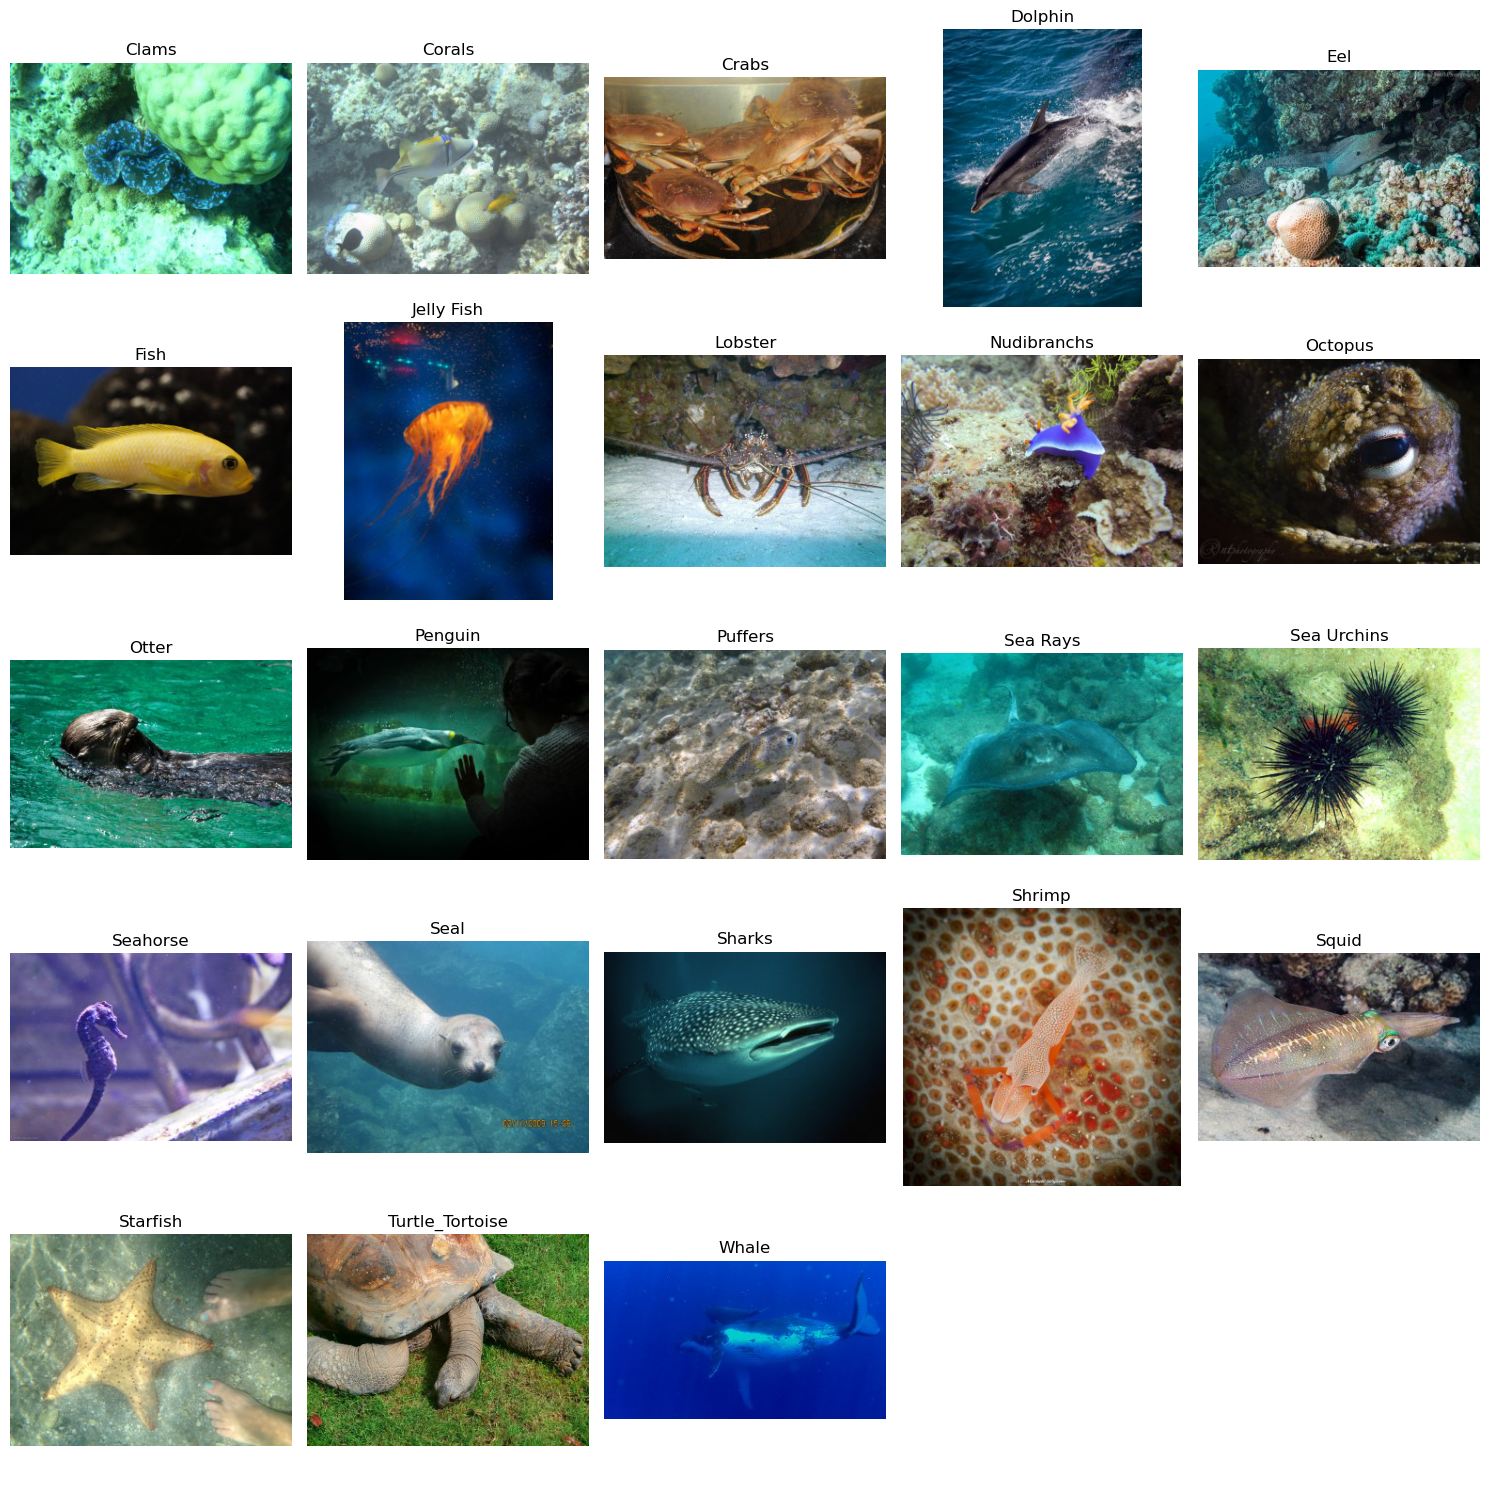

In [12]:
# Visualize sample images from each class
class_names = dataset.classes
visualise_class_images(dataset, class_names)

### Model Training

In [68]:
num_classes = len(dataset.classes)  # Number of classes in your dataset
model = models.resnet18(pretrained=True)  # Load pre-trained ResNet18
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify the final layer

/home/marc/miniconda3/envs/classification/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/marc/miniconda3/envs/classification/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [70]:
num_epochs = 10

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [72]:
# Start MLflow run
with mlflow.start_run():
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("model", "ResNet18")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        mlflow.log_metric("train_loss", epoch_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_accuracy, step=epoch)

        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)


Epoch [1/10], Loss: 1.6360, Train Accuracy: 50.80%
Validation Loss: 1.5784, Validation Accuracy: 55.30%
Epoch [2/10], Loss: 1.1734, Train Accuracy: 63.88%
Validation Loss: 1.4843, Validation Accuracy: 59.14%
Epoch [3/10], Loss: 0.9372, Train Accuracy: 71.15%
Validation Loss: 1.2817, Validation Accuracy: 62.26%
Epoch [4/10], Loss: 0.6939, Train Accuracy: 78.41%
Validation Loss: 1.7301, Validation Accuracy: 56.32%
Epoch [5/10], Loss: 0.5424, Train Accuracy: 83.06%
Validation Loss: 1.4502, Validation Accuracy: 60.41%
Epoch [6/10], Loss: 0.3905, Train Accuracy: 88.03%
Validation Loss: 1.4599, Validation Accuracy: 60.94%
Epoch [7/10], Loss: 0.2965, Train Accuracy: 90.98%
Validation Loss: 1.4528, Validation Accuracy: 65.32%
Epoch [8/10], Loss: 0.2443, Train Accuracy: 92.27%
Validation Loss: 1.7132, Validation Accuracy: 62.21%
Epoch [9/10], Loss: 0.1916, Train Accuracy: 94.11%
Validation Loss: 1.6264, Validation Accuracy: 62.84%
Epoch [10/10], Loss: 0.1718, Train Accuracy: 94.77%
Validation L

In [73]:
# Save the model
mlflow.pytorch.log_model(model, "model")

In [74]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
mlflow.log_metric("test_loss", test_loss)
mlflow.log_metric("test_accuracy", test_accuracy)

Test Loss: 1.7921, Test Accuracy: 60.84%
